In [384]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import QuantileTransformer, StandardScaler
sns.set()

In [641]:
# Read in two csvs from previous file
usage=pd.read_csv("../Data_processed/usage_clean.csv", index_col=0, parse_dates=["duolingo_start_date"])
survey=pd.read_csv("../Data_processed/survey_clean.csv", index_col=0)

In [642]:
usage.head(3)

,user_id,duolingo_start_date,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,35cb7e8f72c911e9888edca9049399ef,2018-06-20 21:14:00,0.0,46.0,True,False,277.0,88,741.0,668.0,135,137
1,35ca34fd72c911e99ed6dca9049399ef,2017-08-08 05:01:00,0.0,50.0,True,False,62.0,16,57.0,57.0,6,453
2,35d1a54a72c911e98e25dca9049399ef,2014-10-15 17:55:00,1.0,71.0,False,False,202.0,29,315.0,295.0,55,1481


In [643]:
survey.head(3)

,id,age,income,country,platform,subscriber,usage,employment,contact,gender,commitment,review,motivation,level,student,survey_comp,survey_time,motivation_followup,resources
0,35c9fc6e72c911e99681dca9049399ef,Y,2,JP,A,NVR,D,F,Yes,Male,3,Review,6,Advanced,No,1,193,"['want', 'learn', 'many', 'language', 'can', '...","['story', 'novel', 'child', 's', 'book', 'movi..."
1,35c9fdde72c911e98630dca9049399ef,Y,2,JP,I,NVR,W,F,Yes,Male,1,Review,0,Intermediate,No,1,139,"['immigrant', 'refugee']",[]
2,35c9feb072c911e9ab4cdca9049399ef,Y,3,JP,I,YES,D,F,Yes,Male,2,Review,4,Beginner,No,1,119,[],[]


In [644]:
# This part was written at a later time. 
# After vectorizing the documents, we observed a new column also named 'country' which comes from vocab. 
# To prevent confusion, I will change the 'country' column here as nation. 
survey.rename(columns={"country":"nation"}, inplace=True)
survey.head(3)

,id,age,income,nation,platform,subscriber,usage,employment,contact,gender,commitment,review,motivation,level,student,survey_comp,survey_time,motivation_followup,resources
0,35c9fc6e72c911e99681dca9049399ef,Y,2,JP,A,NVR,D,F,Yes,Male,3,Review,6,Advanced,No,1,193,"['want', 'learn', 'many', 'language', 'can', '...","['story', 'novel', 'child', 's', 'book', 'movi..."
1,35c9fdde72c911e98630dca9049399ef,Y,2,JP,I,NVR,W,F,Yes,Male,1,Review,0,Intermediate,No,1,139,"['immigrant', 'refugee']",[]
2,35c9feb072c911e9ab4cdca9049399ef,Y,3,JP,I,YES,D,F,Yes,Male,2,Review,4,Beginner,No,1,119,[],[]


In [645]:
# word count for motivation comments
# Median comment length (after basic preprocessing) = 23
survey.motivation_followup.apply(len).value_counts().describe()

count     107.000000
mean       57.822430
std       238.523122
min         4.000000
25%        11.500000
50%        23.000000
75%        48.000000
max      2472.000000
Name: motivation_followup, dtype: float64

In [646]:
# word count for resources comments
# Median comment length (after basic preprocessing) = 5.5
# We expect smaller vocab for resources 
survey.resources.apply(len).value_counts().describe()

count     162.000000
mean       38.191358
std       149.918716
min         1.000000
25%         2.000000
50%         5.500000
75%        20.000000
max      1713.000000
Name: resources, dtype: float64

## Vectorize the clean/tokenized resources, motivation_followup comments

In [647]:
# Resources
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(survey.resources)
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names()
resource_df=pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
resource_df.head()

,apps,book,child,class,conversation,etc,event,group,in,language,...,private,show,speak,specify,story,textbook,textbooks,tutor,tv,ups
0,0.0,0.42,0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.31,0.0,0.0,0.42,0.0,0.0,0.0,0.31,0.0
1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
2,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
3,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
4,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0


In [648]:
# I would like to customize the vocabulary, but I will come back to it. 
# Textbooks, textbook, book, others, specify 
print(vocab)
print("Sample sentence: "+survey.resources[0])
print(tv.transform([survey.resources[0]]))

['apps', 'book', 'child', 'class', 'conversation', 'etc', 'event', 'group', 'in', 'language', 'meet', 'movie', 'novel', 'online', 'others', 'person', 'please', 'private', 'show', 'speak', 'specify', 'story', 'textbook', 'textbooks', 'tutor', 'tv', 'ups']
Sample sentence: ['story', 'novel', 'child', 's', 'book', 'movie', 'tv', 'show']
  (0, 25)	0.31141621633981703
  (0, 21)	0.4210284493361989
  (0, 18)	0.31141621633981703
  (0, 12)	0.4210284493361989
  (0, 11)	0.31141621633981703
  (0, 2)	0.4210284493361989
  (0, 1)	0.4210284493361989


In [701]:
# From answers from 2238 people, apps was the most 'important' keyword
# followed by movie, conversation, textbooks
resource_df.idxmax(axis=1).value_counts()[:20]

apps            2238
movie            555
please           544
conversation     494
textbook         478
in               459
book             444
online           360
private          237
language         228
textbooks        114
class             36
dtype: int64

In [649]:
# Motivation_followup
tv_motiv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix_motiv = tv_motiv.fit_transform(survey.motivation_followup)
tv_matrix_motiv = tv_matrix_motiv.toarray()
vocab_motiv = tv_motiv.get_feature_names()
motiv_df=pd.DataFrame(np.round(tv_matrix_motiv, 2), columns=vocab_motiv)
motiv_df.head()

,abroad,basic,can,class,communicate,community,connect,country,coworkers,culture,...,understand,upcoming,use,useful,want,watch,way,well,without,would
0,0.0,0.00,0.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.26,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.45,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.46,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [651]:
# Not perfect vocab: in, learn, learning, play, playing 
print(vocab_motiv)
print("Sample sentence: "+survey.motivation_followup[0])
print(tv_motiv.transform([survey.motivation_followup[0]]))

['abroad', 'basic', 'can', 'class', 'communicate', 'community', 'connect', 'country', 'coworkers', 'culture', 'current', 'different', 'duolingo', 'enrol', 'etc', 'expat', 'family', 'find', 'fulfill', 'game', 'get', 'goal', 'good', 'grandchildren', 'grandparent', 'help', 'heritage', 'hobby', 'immigrant', 'in', 'job', 'language', 'learn', 'learning', 'less', 'lifelong', 'like', 'live', 'local', 'many', 'meaningful', 'medium', 'move', 'neighbor', 'news', 'optional', 'people', 'personal', 'placement', 'plan', 'planning', 'play', 'playing', 'please', 'pop', 'prepare', 'read', 'refugee', 'relative', 'relatives', 'require', 'requirement', 'respect', 'show', 'significant', 'social', 'someday', 'speak', 'specify', 'spend', 'study', 'supplement', 'take', 'test', 'time', 'together', 'travel', 'trip', 'understand', 'upcoming', 'use', 'useful', 'want', 'watch', 'way', 'well', 'without', 'would']
Sample sentence: ['want', 'learn', 'many', 'language', 'can', 'please', 'specify']
  (0, 82)	0.256204528

In [702]:
# From answers from 2727 people, abroad was the most 'important' keyword
motiv_df.idxmax(axis=1).value_counts()[:20]

abroad       2727
please        332
less          317
local         316
expat         204
learn         203
refugee       149
good          148
medium        129
job           117
news          113
pop           100
language       96
connect        91
community      77
family         65
trip           60
goal           59
together       58
immigrant      58
dtype: int64

## Visualizing the corpus

In [652]:
corpus = []
for i in range(len(survey)):
    l=survey.resources[i].strip('][').replace("'","").split(', ')
    if "" not in l:
        corpus.append(l)
flattened_corpus = []

#flatten the lis
for l in corpus:
    for word in l:
        flattened_corpus.append(word)
        
corpus_motiv = []
for i in range(10):
    l=survey.motivation_followup[i].strip('][').replace("'","").split(', ')
    if "" not in l:
        corpus_motiv.append(l)
flattened_corpus_motiv = []

#flatten the lis
for l in corpus_motiv:
    for word in l:
        flattened_corpus_motiv.append(word)

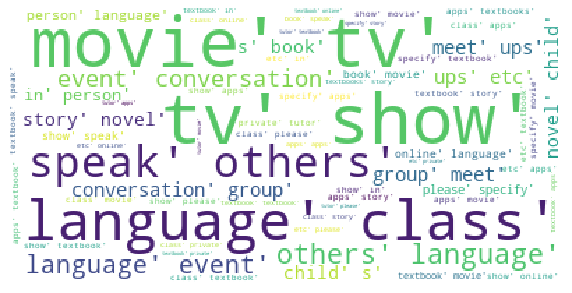

In [653]:
# Want to get rid of quotation marks 
stop_words = stopwords.words("english")
wordcloud = WordCloud(background_color='white',
                      stopwords=stop_words,
                      max_words=100,
                      max_font_size=50, 
                      random_state=42).generate(str(flattened_corpus))
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("../Data_processed/resources.png", dpi=900)

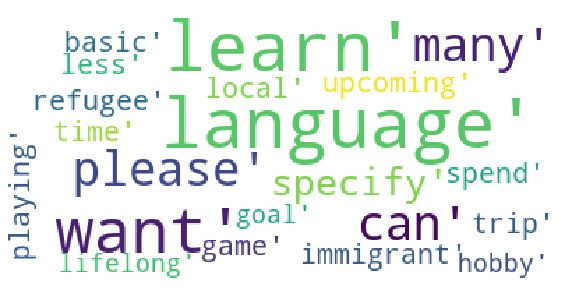

In [654]:
wordcloud = WordCloud(background_color='white',
                      stopwords=stop_words,
                      max_words=100,
                      max_font_size=50, 
                      random_state=42).generate(str(flattened_corpus_motiv))
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("../Data_processed/motivation.png", dpi=900)

In [655]:
# Update the dataframe survey with vocab tf-idf 
survey = pd.concat([survey, resource_df], axis=1)
survey = pd.concat([survey, motiv_df], axis=1)
survey.drop(["motivation_followup", "resources"], axis=1, inplace=True)
survey.head(3)

,id,age,income,nation,platform,subscriber,usage,employment,contact,gender,...,understand,upcoming,use,useful,want,watch,way,well,without,would
0,35c9fc6e72c911e99681dca9049399ef,Y,2,JP,A,NVR,D,F,Yes,Male,...,0.0,0.0,0.0,0.0,0.26,0.0,0.0,0.0,0.0,0.0
1,35c9fdde72c911e98630dca9049399ef,Y,2,JP,I,NVR,W,F,Yes,Male,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,35c9feb072c911e9ab4cdca9049399ef,Y,3,JP,I,YES,D,F,Yes,Male,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [656]:
# combine usage and survey
combined=survey.merge(usage, left_on="id", right_on="user_id", how="inner")
combined.head(3)

,id,age,income,nation,platform,subscriber,usage,employment,contact,gender,...,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,35c9fc6e72c911e99681dca9049399ef,Y,2,JP,A,NVR,D,F,Yes,Male,...,0.0,58.0,True,False,275.0,91,232.0,232.0,589,849
1,35c9fdde72c911e98630dca9049399ef,Y,2,JP,I,NVR,W,F,Yes,Male,...,20.0,4.0,True,False,22.0,54,90.0,88.0,27,125
2,35c9feb072c911e9ab4cdca9049399ef,Y,3,JP,I,YES,D,F,Yes,Male,...,0.0,11.0,False,True,17.0,30,49.0,47.0,30,479


In [660]:
# Drop duplicate id's
combined.drop_duplicates(subset=["id"], keep="first", inplace=True) 
combined.drop("user_id", axis=1, inplace=True)

In [662]:
combined=combined.reset_index().drop("index", axis=1)
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Columns: 143 entries, id to n_days_on_platform
dtypes: bool(2), datetime64[ns](1), float64(120), int64(8), object(12)
memory usage: 6.6+ MB


In [693]:
combined.to_csv("../Data_processed/combined.csv")

## Convert all columns to numerics

In [663]:
# Ave age value per group
combined_num=pd.DataFrame(combined.age.map({"T":15, "Y":26, "M":44.5, "O":64.3, "S":80}), columns=["age"])
# Ave income value per group
combined_num["income"]=combined.income.map({0:5, 1:18, 2:50.5, 3:113, 4:300})

In [664]:
# Add one hot encoded countries
combined_num=pd.concat([combined_num, pd.get_dummies(combined.nation, drop_first=True)], axis=1)
combined_num=pd.concat([combined_num, pd.get_dummies(combined.platform, drop_first=True)], axis=1)

In [666]:
# Subscriber
combined_num=pd.concat([combined_num, pd.get_dummies(combined.subscriber, drop_first=True)], axis=1)
# Frequency of usage
combined_num["usage"]=combined.usage.map({"D":30, "W":4, "M":1,"S":0.3})
# Employment
combined_num=pd.concat([combined_num, pd.get_dummies(combined.employment, drop_first=True)], axis=1)

In [667]:
combined_num=pd.concat([combined_num, pd.get_dummies(combined.contact, drop_first=True)], axis=1)
combined_num=pd.concat([combined_num, pd.get_dummies(combined.gender, drop_first=True)], axis=1)
combined_num=pd.concat([combined_num, pd.get_dummies(combined.review, drop_first=True)], axis=1)
combined_num["commitment"]=combined.commitment

combined_num=pd.concat([combined_num, pd.get_dummies(combined.motivation, drop_first=True)], axis=1)
combined_num["level"]=combined.level.map({"Beginner":0, "Intermediate":1, "Advanced":2})
combined_num["student"]=combined.student.map({"Full":1, "Part":0.5, "No":0})

In [668]:
combined_num=pd.concat([combined_num, pd.get_dummies(combined.survey_comp, drop_first=True)], axis=1)
combined_num["survey_time"]=combined.survey_time

In [669]:
combined_num=pd.concat([combined_num, combined.loc[:,"apps":"would"]], axis=1)

In [670]:
combined_num["year_month"]=combined.duolingo_start_date.map(lambda x: 100*x.year + x.month)

In [673]:
combined_num=pd.concat([combined_num, combined.loc[:, "daily_goal":]], axis=1)

In [674]:
combined_num.head(3)

,age,income,CO,DE,FR,GB,JP,MX,RU,TW,...,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,26.0,50.5,0,0,0,0,1,0,0,0,...,0.0,58.0,True,False,275.0,91,232.0,232.0,589,849
1,26.0,50.5,0,0,0,0,1,0,0,0,...,20.0,4.0,True,False,22.0,54,90.0,88.0,27,125
2,26.0,113.0,0,0,0,0,1,0,0,0,...,0.0,11.0,False,True,17.0,30,49.0,47.0,30,479


## Scale numerics in prepation for KMeans

In [675]:
# Compare different scalers
scaled_features = StandardScaler().fit_transform(combined_num[["age", "income","n_active_days"]].values)
qfeatures=QuantileTransformer(n_quantiles=10, random_state=0).fit_transform(combined_num[["age", "income", "n_active_days"]].values)

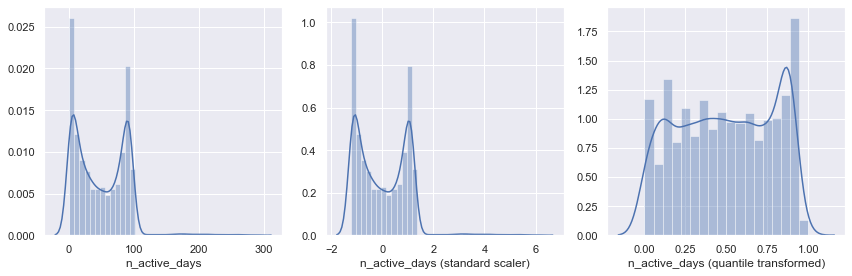

In [676]:
plt.subplots(figsize=(12,4))
plt.subplot(1,3,1)
sns.distplot(combined_num.n_active_days)
plt.subplot(1,3,2)
sns.distplot(pd.DataFrame(scaled_features).loc[:,2])
plt.xlabel("n_active_days (standard scaler)")
plt.subplot(1,3,3)
sns.distplot(pd.DataFrame(qfeatures).loc[:,2])
plt.xlabel("n_active_days (quantile transformed)")
plt.tight_layout()

In [678]:
# Save a new data frame that is scaled
qt=QuantileTransformer(n_quantiles=10, random_state=0).fit_transform(
    combined_num.to_numpy())
colnames=combined_num.columns
combine_scaled=pd.DataFrame(qt, columns=colnames)

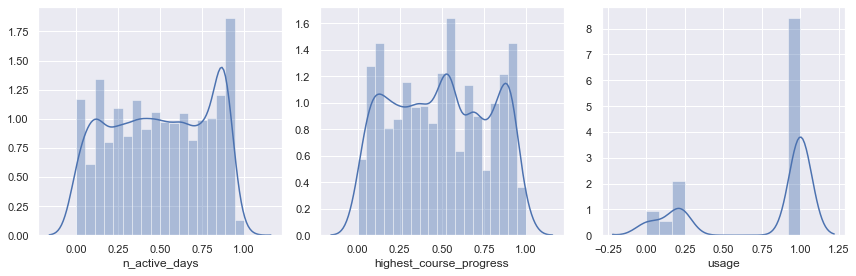

In [680]:
# Check out some column distributions. 
plt.subplots(figsize=(12,4))
plt.subplot(1,3,1)
sns.distplot(combined_scaled.n_active_days)
plt.subplot(1,3,2)
sns.distplot(combined_scaled.highest_course_progress)
plt.subplot(1,3,3)
sns.distplot(combined_scaled.usage)
plt.tight_layout()

In [689]:
combine_scaled.to_csv("../Data_Processed/combined_features_scaled.csv")

In [695]:
combine_scaled.tail(3)

,age,income,CO,DE,FR,GB,JP,MX,RU,TW,...,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
6076,0.833333,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.611111,0.455556,1.0,0.0,0.376812,0.555556,0.288360,0.301449,0.719298,0.287778
6077,0.833333,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.555556,1.0,1.0,0.719577,0.511111,0.596405,0.623932,0.481481,0.595537
6078,0.833333,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.888889,0.862745,0.0,1.0,0.381643,0.727273,0.774306,0.782896,0.711501,0.790526
